In [1]:
import os
import sys
import time
import serial
import serial.tools.list_ports
import datetime #as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.optimize import curve_fit
import math

from scipy.stats import shapiro
from scipy.stats import f_oneway
from scipy import signal
from scipy.stats import alexandergovern
from scipy.stats import kruskal
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
from scipy.stats import lognorm
from scipy.stats import f as fSnedecora
import statistics

In [2]:
'''Wskazanie miejsca zapisu próbek, nazw plików csv i numerów grup'''

dir='D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/'
numberOfGroup=[1,2,3,4]
disp='test.csv'
force='ID00_CH00_WeightScale2kN.csv'
volt='ID01_CH00_Analog1.csv'

global dir_img
dir_img='D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/img/'

In [22]:
class ChangeDataNames:
    '''
    
    '''
    
    def __init__(self,df_force,df_volt):
        self.df_force=df_force
        self.df_volt=df_volt
        
    def correctDataAndName(self,area):

        self.df_force=self.df_force.rename(columns={'Mass [g]': 'Force', "time [ms]": 'timeF'})
        self.df_volt=self.df_volt.rename(columns={'Voltage [mV]': 'Voltage', "time [ms]": 'timeV'})
        
        
        self.df_force.Force=self.df_force.Force*0.0098105 
        
        
        '''Pomyśleć czy potrzebne - Zamien na Sawickiego Golaya'''
        #self.df_force.Force=Calculus.averagingFilter(self.df_force.Force,3)
        window_length=5
        polyorder=2 #less then window
        self.df_force.Force=signal.savgol_filter(self.df_force.Force, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)
        
        
        self.df_force.timeF=self.df_force.timeF/1000
        self.df_volt.timeV=self.df_volt.timeV/1000
        self.df_force['Stress']=self.df_force.Force/area
        #self.df_volt.Voltage=self.df_volt.Voltage/10

            

        self.df_force.Force=self.df_force.Force-self.df_force.Force.iloc[0]
            #df2[dfForceName]=df2[dfForceName].ewm(com = 0.4).mean()
        self.df_force.reset_index(drop=True) 
        self.df_volt.reset_index(drop=True)

        dfnew=pd.concat([self.df_volt, self.df_force.reindex(self.df_volt.index)], axis=1)
        
        return dfnew
    
    
    
class SubData:
    
    def __init__(self):
        pass
    @staticmethod    
    def shortExtensions(R):
        sExtensions=pd.DataFrame({ 'A' : range(0,R,1)})
        #czas rozciagania to 3sekundy i próbkowanie = 20sample/s stąd 60
        sExtensions=sExtensions['A']
        sExtensions=sExtensions/10/100
        return sExtensions

class CutterDF(SubData):
    
    def __init__(self,df):
        self.df=df
        
    def idOfMaxStress(self,*stressRanges):
        if len(stressRanges)%2!=0:
            print('Musi być parzysta ilość argumentów dla definicji przedziałów')
        else:
            pass
        maxIdForce=[(self.df.loc[stressRanges[i*2]:stressRanges[i*2+1], 'Stress'].idxmax()) 
                    for i in range (int(len(stressRanges)/2))]   
        return maxIdForce
    
    def cutPartOfRange(self,*stressRanges):
        if len(stressRanges)%2!=0:
            print('Musi być parzysta ilość argumentów dla definicji przedziałów')
        else:
            pass
        #dfshort=self.df.Stress[maxIdForce1-60:maxIdForce1].reset_index(drop=True)
        
        dfshort=[(self.df.Stress[stressRanges[i*2]:stressRanges[i*2+1]].reset_index(drop=True)) 
                 for i in range (int(len(stressRanges)/2))] 

            
        
        #dfshort=dfshort.iloc[::-1]
        return dfshort            

    
class Calculus(SubData):
    def __init__(self):   
        pass

    
    @staticmethod    
    def funcYoung(e,a,b): #współczynnik szybkości relaksacji
        return a*e+b
    @staticmethod    
    def youngFunc(e,s):
    

        #print(e.head(-5))
        #print(s.head(-5))
        plt.figure(figsize=(7,3))

        plt.plot(e,s)
        popt, _ = curve_fit(Calculus.funcYoung, e, s, method='lm')
        a, b=popt
        #print(popt)

        plt.plot(e,s)
        plt.plot(e, Calculus.funcYoung(e, *popt), 'g--') #funkcja pokazująca dopasowane expFunc do rzeczywistej
        #plt.legend()
        plt.show()
        return a
    @staticmethod
    def averagingFilter(interval, window_size):
        window = np.ones(int(window_size))/float(window_size)
        return np.convolve(interval, window, 'same') 
    
    '''Sprawdez rozne sposoby liczenia pochodnych'''
    @staticmethod
    def deriattiveDf(x,y):
        d=np.zeros(len(x))
        for i in range(1,len(x)-1):
            d[i]=((x[i+1]-x[i-1])/(y[i+1]-y[i-1]))
            d[0]=d[1]
            
        return d

        
class Ploting(Calculus):
    def __init__(self):
        pass
    
    def plot_histeresis(self,stress_1,stress_2,xlabel,ylabel,title,label_1,label_2):
        extension=SubData.shortExtensions(len(stress_1.to_numpy()))
        stress_2=stress_2.iloc[::-1] #odwrócenie drugiego przebiegu

        plt.figure(figsize=(8,5))
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.plot(extension,stress_1, label=label_1)
        plt.plot(extension,stress_2, label=label_2)
        plt.fill_between(extension, stress_1, stress_2, color='b', alpha=0.2, hatch='/')
        plt.legend()
        plt.show()  
        pass
    def plot_boxScatterdf(self,df,name_1,ylabel,title,ylim_1=0,ylim_2=300):
        noG=df.columns
        name=''.join(noG)
        name=name+'_'+name_1+'_boxplot'
        plt.figure()
        df.boxplot()
        for i, d in enumerate(df):
            y = df[d]
            x = np.random.normal(i + 1, 0.04, len(y))
            plt.scatter(x, y)
        #plt.ylim(10,70)
        plt.ylim(ylim_1,ylim_2)
        plt.title(title)
        plt.ylabel(ylabel)
        plt.savefig(dir_img+name+'.eps', dpi=300)
        plt.show()
    
class StaticCalculus(SubData):
    def __init__(self):   
        pass    
    

    @staticmethod    
    def normalDis(df):
        #listoflists=[]
        for col in df.columns:
            l=dfY[col].tolist()
            stats, p = shapiro(l)
            print(col,stats,p)
            #print(col)
            if p > 0.05:
                print ("Rozkład wygląda na normalny")
            else:
                print('Nienormalny')
            sns.distplot(l)
            #fig, ax = plt.subplots(1, 1)
            #shape, location, scale = stats.lognorm.fit(l)
            #mu, sigma = np.log(scale), shape
            plt.show()
            #listoflists.append(l)
            #print(listoflists[0])

    @staticmethod    
    def annovaTest(df,name_1):
        G=[]         
        for i in list(df.columns):
            g = [x for x in df[i].tolist() if str(x) != 'nan']
            G.append(g)
            #print(G)
        MSTR=0
        MSE=0

        meanG=0
        n=0
        for i in range(len(G)):
            n=n+len(G[i])
            meanG=meanG+sum(G[i])
        meanG=meanG/n
        #print(meanG)

        for i in range(len(G)):
            #print(i)
            meanGi=statistics.mean(G[i])
            SSbetween_group=len(G[i])*(meanGi-meanG)**2
            MSTR=MSTR+SSbetween_group
            #print(meanGi)
            for j in range(len(G[i])):
                SSwithin_group=(G[i][j]-meanGi)**2
                MSE=MSE+SSwithin_group


                #print(j)

        MSTR=MSTR*(1/(len(G)-1))        
        MSE=MSE*(1/(n-len(G)))
        F=MSTR/MSE

        p=fSnedecora.sf(F, len(G)-1, n-len(G)) # F Snedecora 
        #lewo i prawo brzeżnie

        #s,p=f_oneway(G[0],G[1],G[2],G[3])
        #print('pvalue = '+str(p)+'\n')
        print('pvalue = '+str(p)+' F='+str(F)+'\n')
        if p<0.05:
            print('p<0.05\n')
            StaticCalculus.postHocTest(df,name_1)

    @staticmethod    
    def postHocTest(df,name_1):
        x=[]
        j=0
        k=0
        #print(df.stack())
        noG=df.columns
        df.columns.name = 'var_name'
        name=''.join(noG)
        name=name+'_'+name_1+'_TTest'
        #x=df.stack()
        #x.name = 'val'
        #x.reset_index()
        #x.rename(columns={[0]: 'groups', [1]: 'val'}, inplace=True)
        x=pd.melt(df.reset_index(), value_vars=noG, var_name='var_name', value_name='value')
        x.dropna(subset = ["value"], inplace=True)
        #print(x)
        '''
        for i in list(df.columns):

            g = [x for x in df[i].tolist() if str(x) != 'nan']
            x.append(g)
            k=k+j # poprawka Bonferroniego https://pl.wikipedia.org/wiki/Poprawka_Bonferroniego
            j=j+1 # Bonferroniego
            #print(k)
        '''
        
        print('Anderson bez poprawki Bonferroniego')
        print(sp.posthoc_anderson(x,val_col='value', group_col='var_name'))
        print('Ttest bez poprawki Bonferroniego')
        
        print(sp.posthoc_ttest(x,val_col='value', group_col='var_name'))
        print('Ttest z poprawką Bonferroniego')
        print(sp.posthoc_ttest(x,val_col='value', group_col='var_name',p_adjust='bonferroni'))
        #print(k)
        plt.figure()
        heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
        pc=sp.posthoc_ttest(x,val_col='value', group_col='var_name',p_adjust='bonferroni')  # *k - Bonferroniego
        sp.sign_plot(pc, **heatmap_args)
        plt.savefig(dir_img+name+'.eps', dpi=300)
        plt.show()

class Parameters(Calculus,SubData):
    def __init__(self,df):
        self.df=df
        
    def young(self,shortStress,rangeOfStraight):

        shortStress=shortStress[-rangeOfStraight:]    
        extension=SubData.shortExtensions(rangeOfStraight)
        modulYounga=Calculus.youngFunc(extension,shortStress)
        return modulYounga
        
    def dropOfStress(self,maxIdForce,endRel):

        dropStress=((self.df.Stress.iloc[maxIdForce]-self.df.Stress.iloc[endRel])/self.df.Stress.iloc[maxIdForce]*100)
        
        return dropStress
    
    def areaOfHisteresis(self,stress_1,stress_2):
        extension=SubData.shortExtensions(len(stress_1.to_numpy()))
        
        area1=np.trapz(stress_1.to_numpy(), x=extension.to_numpy())
        area2=np.trapz(stress_2.to_numpy(), x=extension.to_numpy())
        histeresis=area1-area2
        return histeresis
    
    def dropOfElasticModulus(self,young1,young2):
        dropOfYoung=(young2/young1)*100
        return dropOfYoung
    
    def voltMax(self,z1,z2):
        maxVolt = self.df.Voltage.loc[int(z1):int(z2)].max()
        return maxVolt

    def inflectionPoint(self,stress,rangeOfStraight):
        stress=stress[-rangeOfStraight:]
        extension=SubData.shortExtensions(rangeOfStraight)
        
        window_length=31#rangeOfStraight-29
        polyorder=7 #less then window #1
        plt.plot(stress)
        stress=signal.savgol_filter(stress, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)
        
        ds_1=Calculus.deriattiveDf(extension,stress)
        window_length=7
        polyorder=1 #less then window        
        #ds_1=signal.savgol_filter(ds_1, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)

        
        #ds_2=Calculus.deriattiveDf(extension[:-1],ds_1)
        #window_length=7
        #polyorder=1#less then window        
        #ds_2=signal.savgol_filter(ds_2, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)

        #dff=Calculus.deriattiveDf(extension,Calculus.deriattiveDf(extension,stress))
        #'''
        plt.plot(stress)
        plt.show()

        plt.plot(ds_1)
        plt.ylim(0,0.1)
        plt.grid()
        plt.show()
        #plt.plot(ds_2)
        #plt.show()
        #'''
        p=rangeOfStraight-next(x[0] for x in enumerate(ds_1[::-1]) if x[1] > 0.012)
        
        
        '''
        Znajdz mediane dla przebiegu ostatnich 5-10 punktow jakos i wyzeruj 
        wzglem niej  a potem warunek jak na górze
        
                
        most_common = max(list(ds_1[-10:-1]), key = list(ds_1).count)
        print(most_common)
        ds_1=ds_1-most_common
        p=rangeOfStraight-next(x[0] for x in enumerate(ds_1[::-1]) if x[1] > 0.05)
        plt.plot(ds_1)
        plt.ylim(0,0.1)
        plt.grid()
        plt.show()
        
        '''
        #print(60-p)
        return p

[467, 12631, 12451]


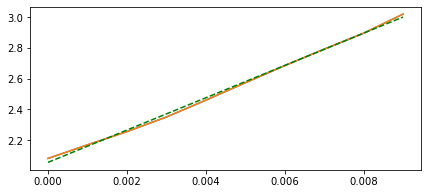

105.12316796656123


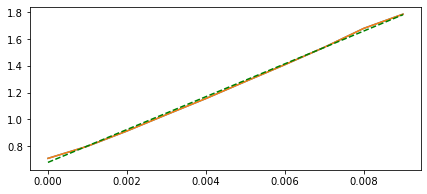

122.54348485477261


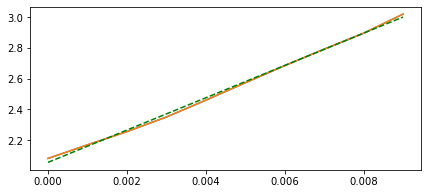

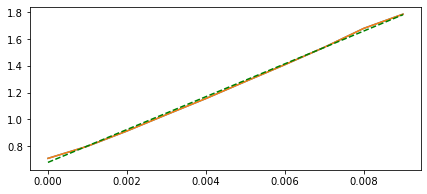

116.57133933953803
0.050011421839805684
nan
0.04307896157427056
55.70919248472722


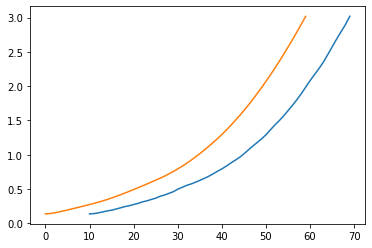

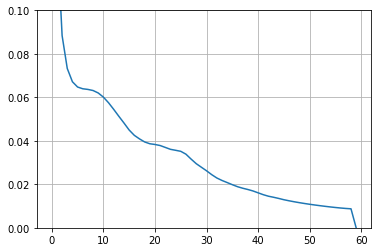

47


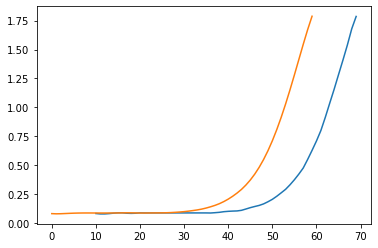

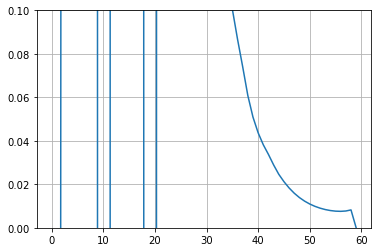

50


In [23]:
df0= pd.read_csv ('g1.csv')
strGroup='1'

newDir=dir+'G102/'
try:
    dfarea=df0['g102.STL'].nsmallest(50)
except:
    dfarea=df0['G102.STL'].nsmallest(50)
#try:
#    dfarea=df0['g'+str(numGroup)+str(i).zfill(2)+'.STL'].nsmallest(50)
#except:
#   dfarea=df0['G'+str(numGroup)+str(i).zfill(2)+'.STL'].nsmallest(50)
area=dfarea.mean()

df2 = pd.read_csv (newDir+force, delimiter=';',decimal=',')
df3 = pd.read_csv (newDir+volt, delimiter=';',decimal=',')  

a=ChangeDataNames(df2,df3)
b=a.correctDataAndName(area)
    
#print(b)

c=CutterDF(b)

d=c.idOfMaxStress(0,4000,12500,14000)
#                 first peak,second peak, end of first relaxation
d=c.idOfMaxStress(0,4000,12500,15000,d[0]+11985 -5,d[0]+11985 +10)
print(d)
#print(e)
e=d
print(c)
            #afe=dfnew[dfStressName][maxIdForce1-60:maxIdForce1].reset_index(drop=True)
            #afr=dfnew[dfStressName][end_fisrtRel:end_fisrtRel+60].reset_index(drop=True)
            #ase=dfnew[dfStressName][maxIdForce2-60:maxIdForce2].reset_index(drop=True)
            #asr=dfnew[dfStressName][maxIdForce2+60:maxIdForce2+120].reset_index(drop=True)
f=c.cutPartOfRange(e[0]-70,e[0],e[2],e[2]+70,e[1]-70,e[1],e[1]+70,e[1]+140)
#print(f)
h=Calculus()


#plot_histeresis(stress_1,stress_2,extension,xlabel,ylabel,title,label_1,label_2)


l=Parameters(b)

print(l.young(f[0],10))
print(l.young(f[2],10))
print(l.dropOfElasticModulus(l.young(f[0],10),l.young(f[2],10)))

print(l.areaOfHisteresis(f[0],f[1]))
print(l.areaOfHisteresis(f[2],f[3]))
print(l.areaOfHisteresis(f[0],f[2]))
print(l.dropOfStress(e[0],e[2]))



print(l.inflectionPoint(f[0],60))
print(l.inflectionPoint(f[2],60))

In [5]:
def dataProcessing(numGroup):
    df0= pd.read_csv ('g'+str(numGroup)+'.csv')
   
    dfG= pd.DataFrame({'A' : []})
    
    for i in range(1,13):
        strGroup='G'+str(numGroup)+str(i).zfill(2)
        newDir=dir+strGroup+'/'
        print(newDir)

        try:
            try:
                dfarea=df0['g'+str(numGroup)+str(i).zfill(2)+'.STL'].nsmallest(50)
            except:
                dfarea=df0['G'+str(numGroup)+str(i).zfill(2)+'.STL'].nsmallest(50)
            area=dfarea.mean()
            dfForce = pd.read_csv (newDir+force, delimiter=';',decimal=',')
            dfVolt = pd.read_csv (newDir+volt, delimiter=';',decimal=',') 

        
            changedata=ChangeDataNames(dfForce,dfVolt)
            
            cutedf=CutterDF(changedata.correctDataAndName(area))
            imaxs=cutedf.idOfMaxStress(0,4000,12500,15000)
            #first peak,second peak, end of first relaxation
            #e=c.idOfMaxStress(0,4000,12500,15000,d[0]+11985 -5,d[0]+11985 +10)
            #e=c.idOfMaxStress(0,4000,12500,15000,d[1]-200 ,d[1]-60)
            imaxs.append(imaxs[1]-180)
            print(imaxs)
            f=cutedf.cutPartOfRange(imaxs[0]-70,imaxs[0],imaxs[2],imaxs[2]+70,imaxs[1]-70,imaxs[1],imaxs[1]+70,imaxs[1]+140)

            parameters=Parameters(changedata.correctDataAndName(area))

            #print(l.young(f[0],10))
            #print(l.young(f[2],10))
            #print(l.dropOfElasticModulus(l.young(f[0],10),l.young(f[2],10)))

            #print(l.areaOfHisteresis(f[0],f[1]))
            #print(l.areaOfHisteresis(f[2],f[3]))
            #print(l.areaOfHisteresis(f[0],f[2]))

            inflPoint_1=parameters.inflectionPoint(f[0],60)
            inflPoint_2=parameters.inflectionPoint(f[2],60)#parameters.young(f[0],10),
            if inflPoint_1 >50:
                inflPoint_1=50
            if inflPoint_2 >50:
                inflPoint_2=50
            listOfParameters=[parameters.young(f[0],60-inflPoint_1),parameters.young(f[2],60-inflPoint_2),parameters.areaOfHisteresis(f[0],f[1]),
                              parameters.areaOfHisteresis(f[2],f[3]),parameters.areaOfHisteresis(f[0],f[2]),
                              parameters.dropOfStress(imaxs[0],imaxs[2])]
            
            
            listOfParameters.append((listOfParameters[1]/listOfParameters[0])*100)
            listOfParameters.append(inflPoint_1)
            listOfParameters.append(inflPoint_2)
            listOfParameters.append(inflPoint_1/inflPoint_2*100)

            #dfPara = pd.DataFrame(listOfParameters)
            dfPara = pd.DataFrame(listOfParameters, columns=[strGroup])
            print(dfPara)
            dfG=pd.concat([dfPara, dfG.reindex(dfG.index)],axis=1)
            



            j=Ploting()
            ####j.plot_histeresis(f[0],f[2],'Strain','Stress [MPa]','Histeresis between first and second extension '+strGroup,"first peak","second peak")
            #j.plot_histeresis(f[0],f[1],'Strain','Stress [MPa]','Histeresis between first extension and relief  '+strGroup,"extension","relief")
            #j.plot_histeresis(f[2],f[3],'Strain','Stress [MPa]','Histeresis between second extension and relief '+strGroup,"extension","relief")
        except:
            print(f'próbka: {strGroup}  jest uszkodzona/odrzucona etc...')
    
    dfG.drop('A', inplace=True, axis=1)
    return dfG.T

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G101/
[592, 12755, 12575]


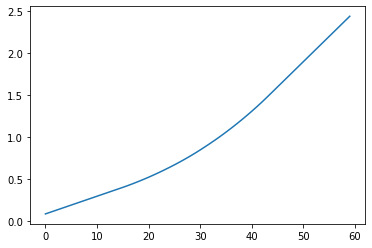

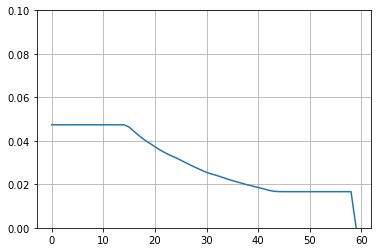

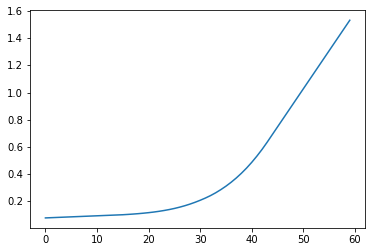

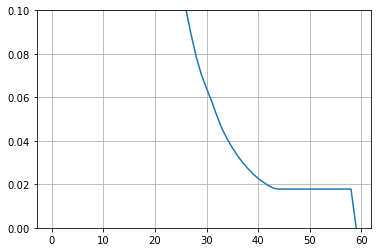

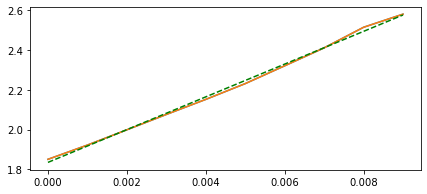

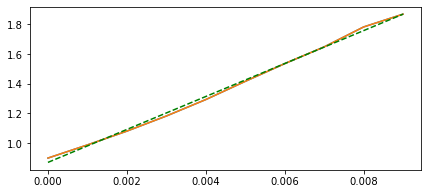

         G101
0   82.446558
1  111.051566
2    0.041389
3         NaN
4    0.034501
5   39.448713
6  134.695213
7   50.000000
8   50.000000
9  100.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G102/
[467, 12631, 12451]


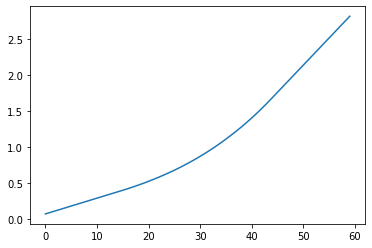

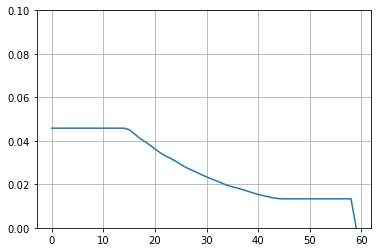

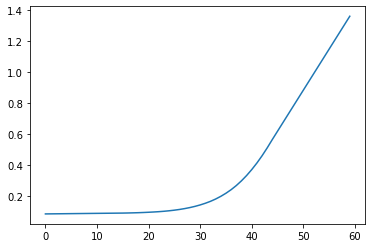

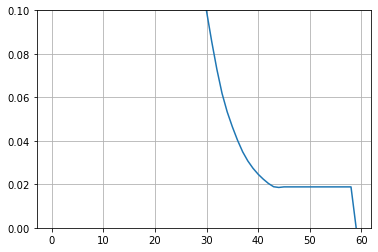

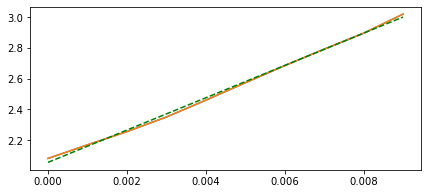

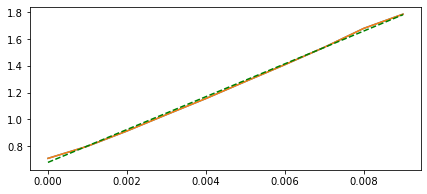

         G102
0  105.123168
1  122.543485
2    0.050011
3         NaN
4    0.043079
5   56.940517
6  116.571339
7   50.000000
8   50.000000
9  100.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G103/
[431, 12595, 12415]


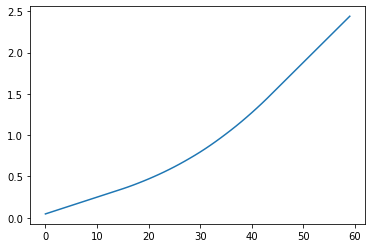

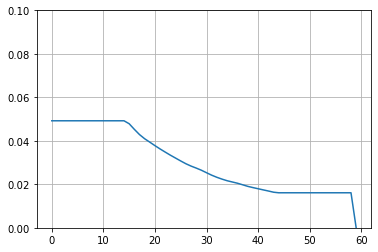

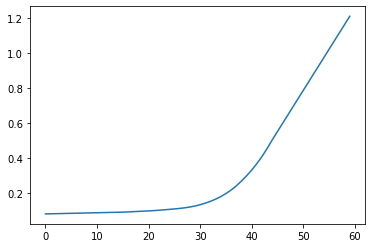

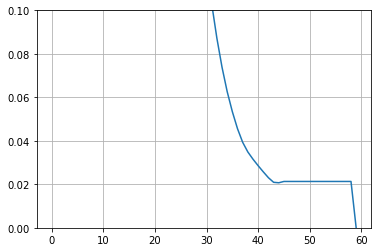

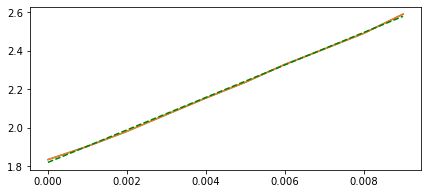

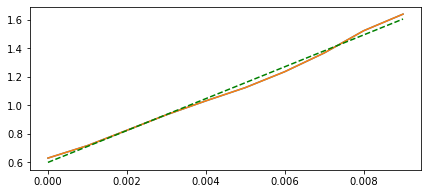

         G103
0   84.244226
1  111.603834
2    0.044612
3         NaN
4    0.037848
5   51.504580
6  132.476537
7   50.000000
8   50.000000
9  100.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G104/
próbka: G104  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G105/
próbka: G105  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G106/
[478, 12643, 12463]


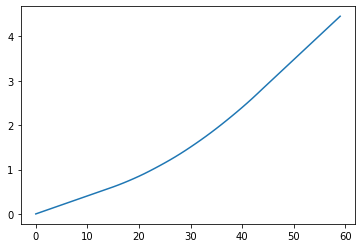

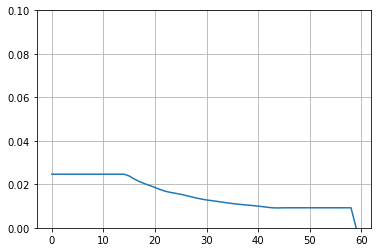

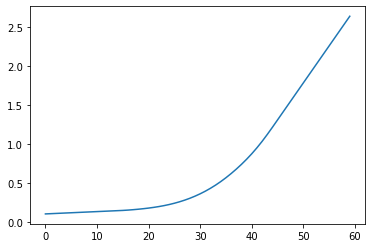

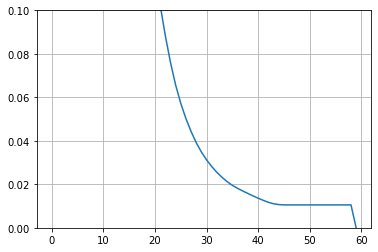

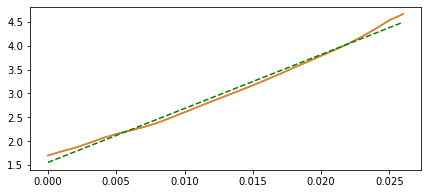

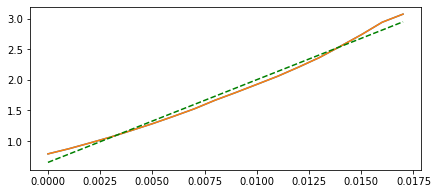

         G106
0  113.142586
1  135.100993
2    0.074583
3         NaN
4    0.061614
5   50.246596
6  119.407730
7   33.000000
8   42.000000
9   78.571429
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G107/
próbka: G107  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G108/
[467, 12630, 12450]


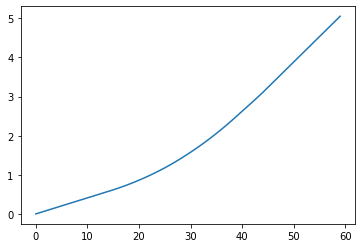

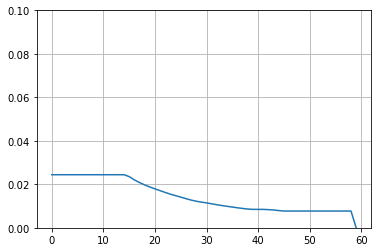

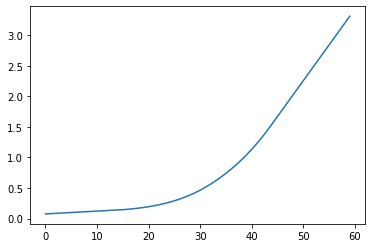

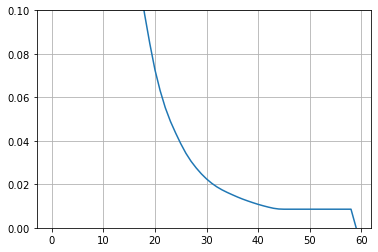

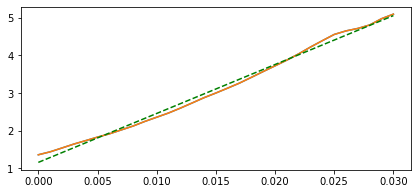

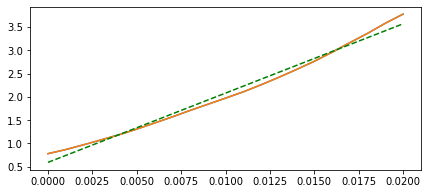

         G108
0  129.739895
1  148.716859
2    0.076804
3         NaN
4    0.060463
5   43.938734
6  114.626930
7   29.000000
8   39.000000
9   74.358974
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G109/
[430, 12594, 12414]


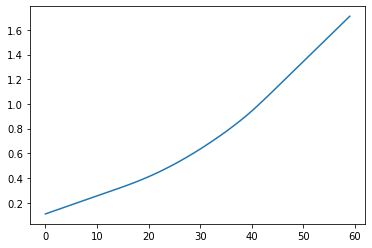

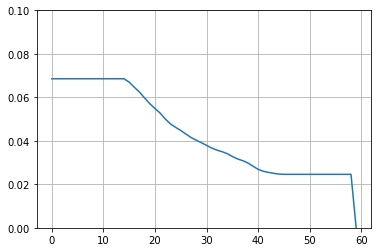

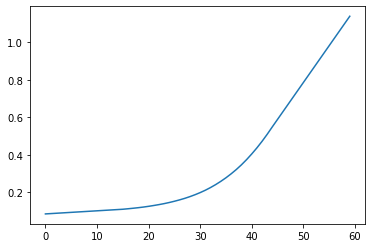

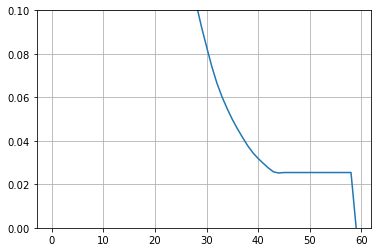

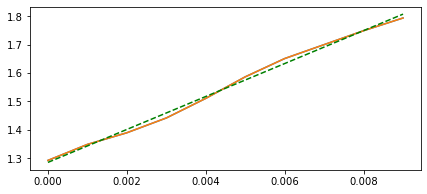

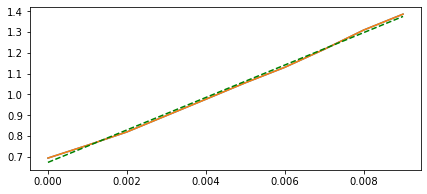

         G109
0   57.979718
1   77.888608
2    0.030424
3         NaN
4    0.023304
5   47.795153
6  134.337680
7   50.000000
8   50.000000
9  100.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G110/
[430, 12594, 12414]


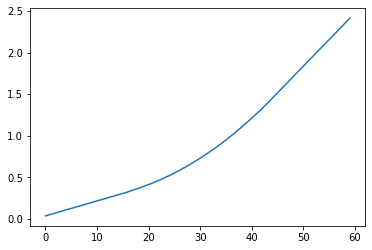

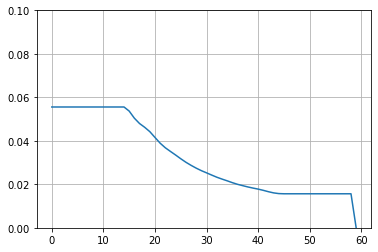

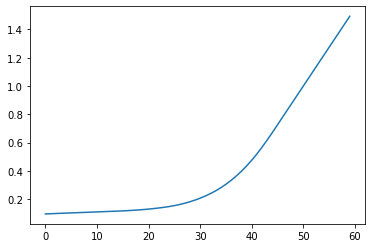

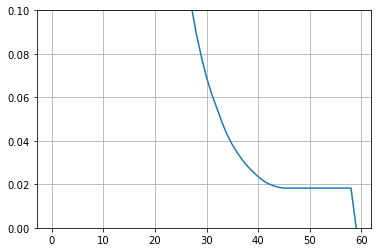

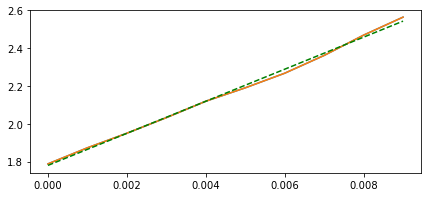

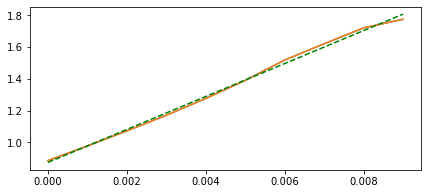

         G110
0   84.818687
1  103.393028
2    0.037473
3         NaN
4    0.028940
5   47.662602
6  121.898879
7   50.000000
8   50.000000
9  100.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G111/
[479, 12643, 12463]


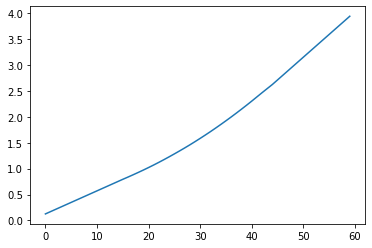

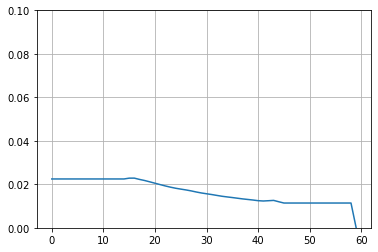

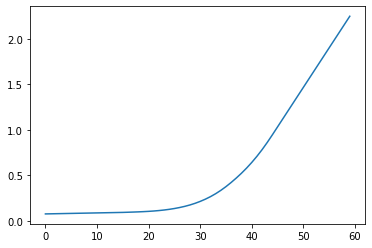

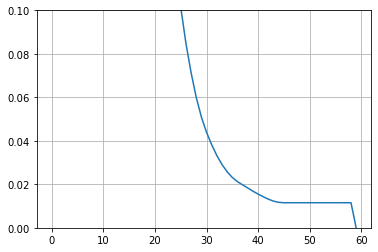

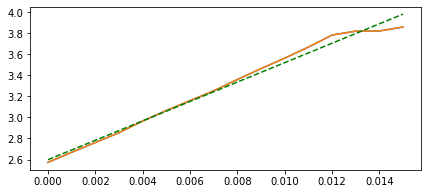

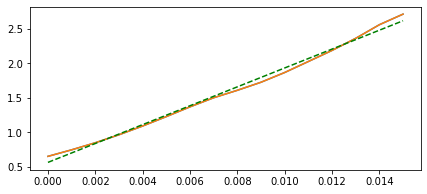

         G111
0   92.229070
1  136.694344
2    0.085601
3         NaN
4    0.071628
5   57.232191
6  148.211778
7   44.000000
8   44.000000
9  100.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G112/
[444, 12607, 12427]


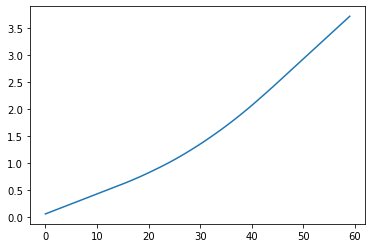

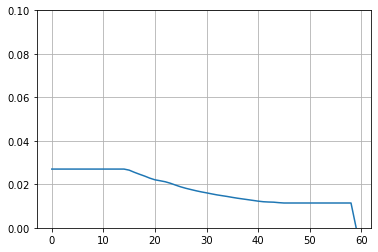

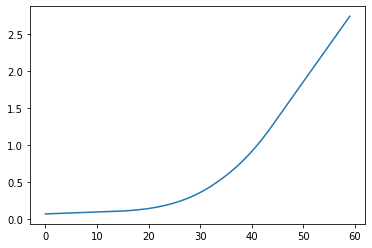

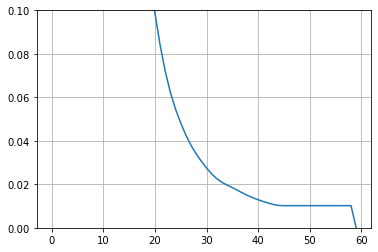

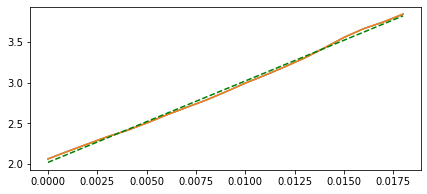

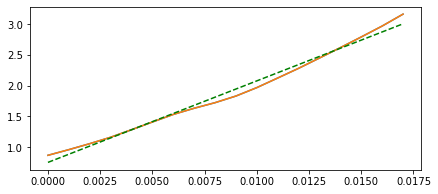

         G112
0  100.181579
1  132.680485
2    0.066310
3         NaN
4    0.049039
5   45.564865
6  132.440002
7   41.000000
8   42.000000
9   97.619048
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G201/
[418, 12582, 12402]


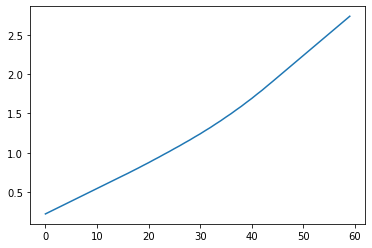

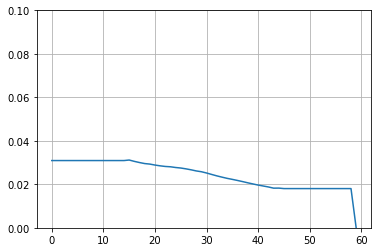

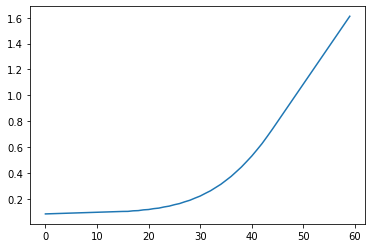

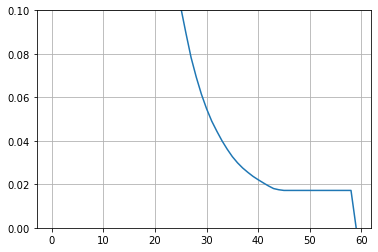

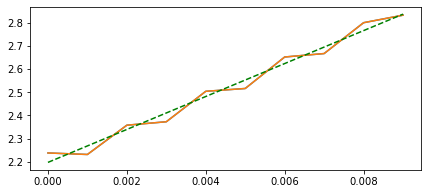

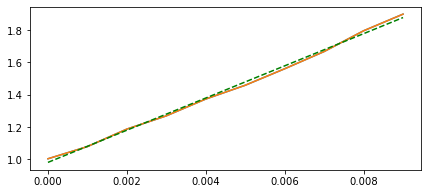

         G201
0   71.013840
1   99.609012
2    0.061588
3         NaN
4    0.053801
5   46.291273
6  140.267042
7   50.000000
8   50.000000
9  100.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G202/
próbka: G202  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G203/
próbka: G203  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G204/
próbka: G204  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G205/
[493, 12657, 12477]


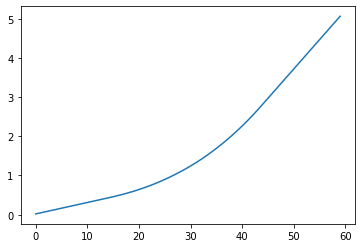

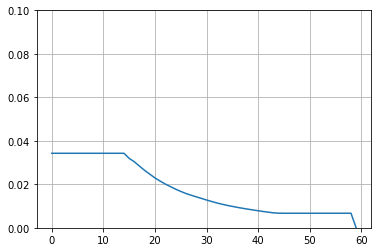

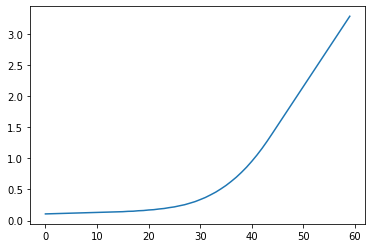

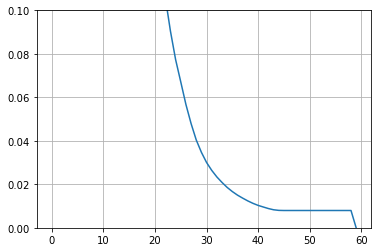

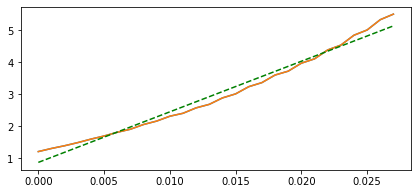

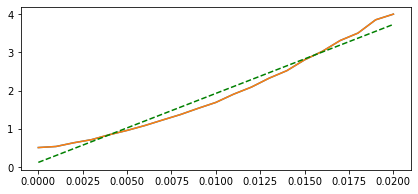

         G205
0  158.268646
1  180.428131
2    0.068380
3         NaN
4    0.051537
5   45.574857
6  114.001184
7   32.000000
8   39.000000
9   82.051282
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G206/
[442, 12606, 12426]


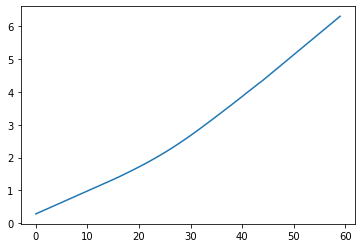

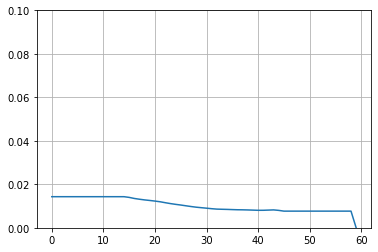

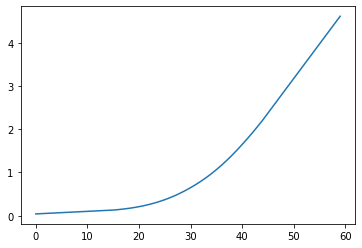

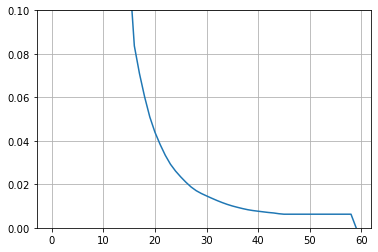

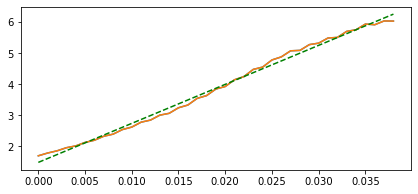

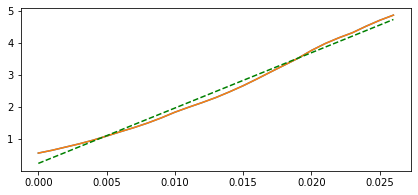

         G206
0  125.338443
1  172.893225
2    0.129169
3         NaN
4    0.101367
5   46.968095
6  137.941098
7   21.000000
8   33.000000
9   63.636364
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G207/
[467, 12631, 12451]


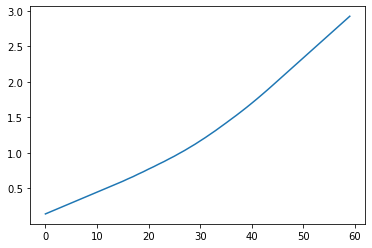

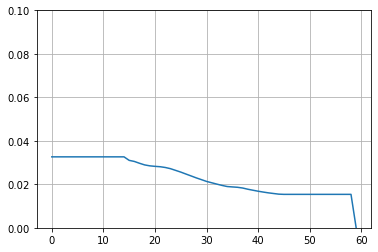

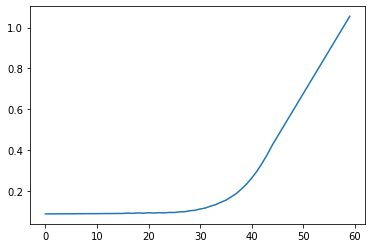

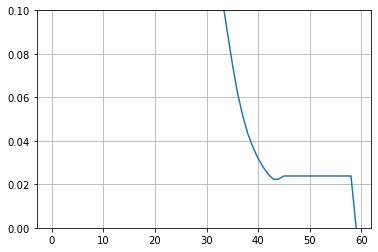

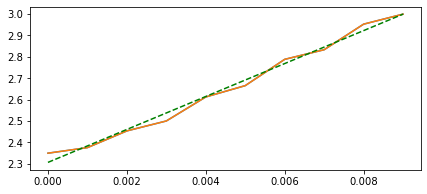

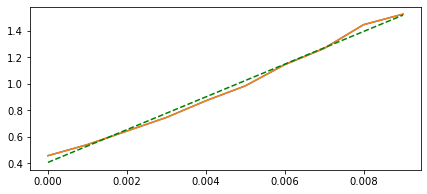

         G207
0   76.983895
1  123.397735
2    0.066137
3         NaN
4    0.060956
5   64.478381
6  160.290324
7   50.000000
8   50.000000
9  100.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G208/
[406, 12570, 12390]


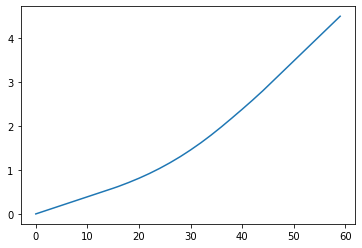

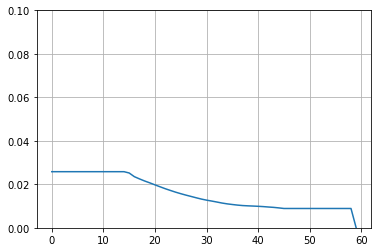

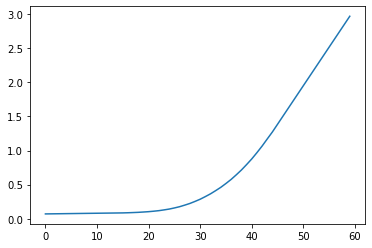

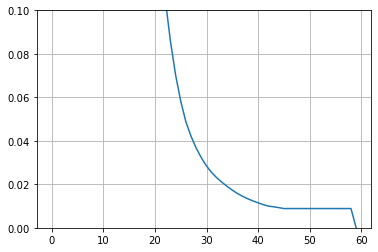

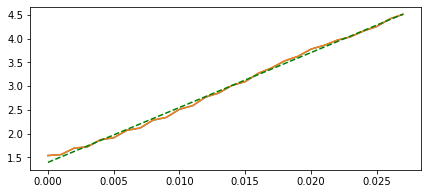

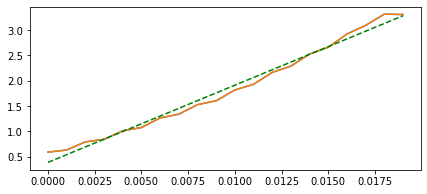

         G208
0  115.588496
1  152.139241
2    0.080716
3         NaN
4    0.060473
5   53.553083
6  131.621438
7   32.000000
8   40.000000
9   80.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G209/
[442, 12605, 12425]


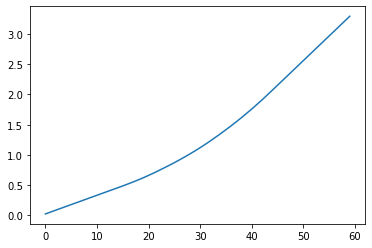

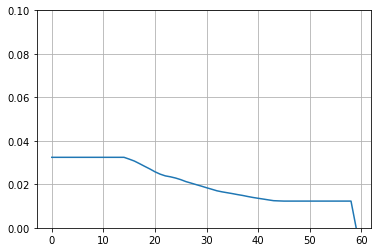

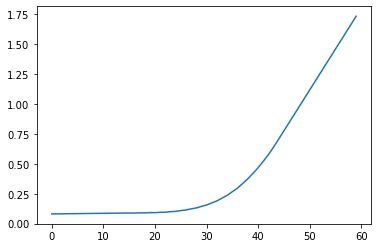

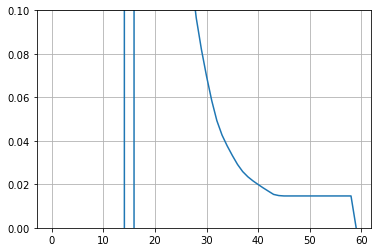

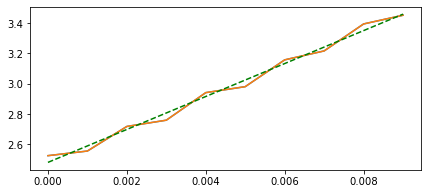

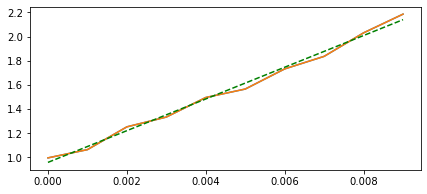

         G209
0  108.533299
1  131.285800
2    0.058631
3         NaN
4    0.052559
5   50.291649
6  120.963614
7   50.000000
8   50.000000
9  100.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G210/
[406, 12570, 12390]


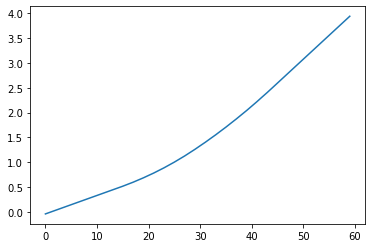

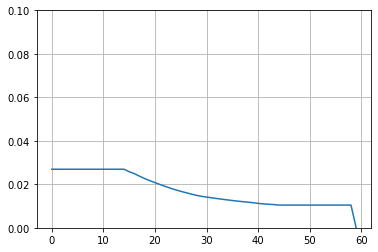

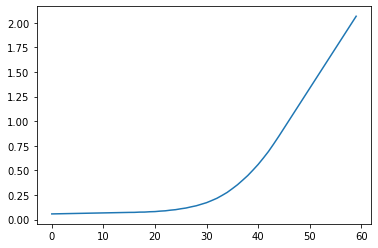

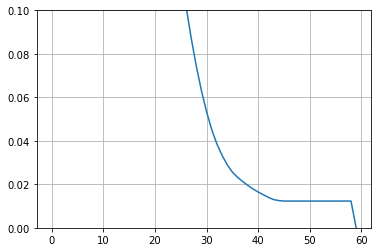

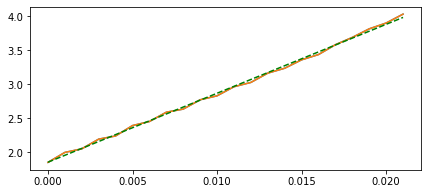

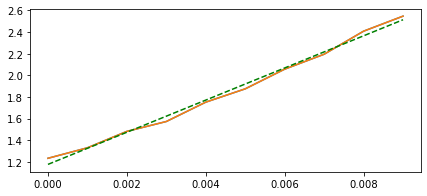

         G210
0  101.197473
1  148.409231
2    0.071739
3         NaN
4    0.062560
5   56.822687
6  146.653100
7   38.000000
8   50.000000
9   76.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G211/
[467, 12630, 12450]


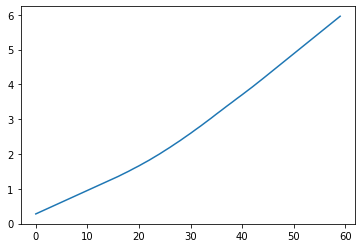

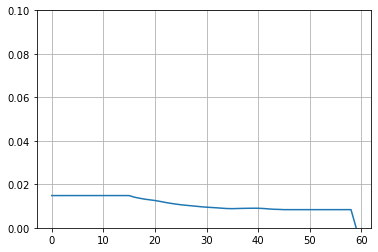

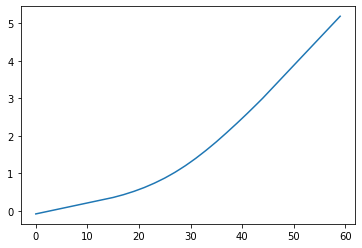

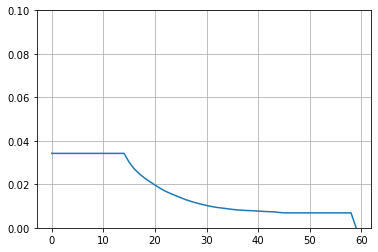

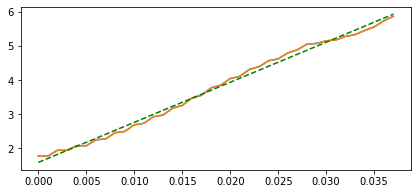

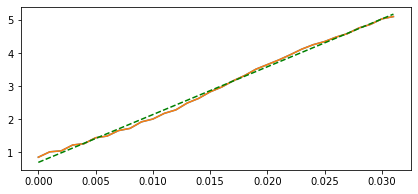

         G211
0  117.339641
1  144.460456
2    0.102142
3         NaN
4    0.063900
5   33.454773
6  123.113089
7   22.000000
8   28.000000
9   78.571429
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G212/
[357, 12520, 12340]


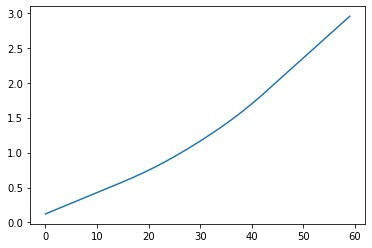

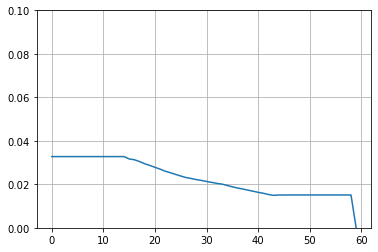

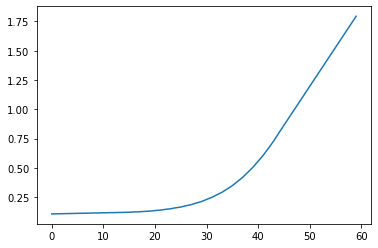

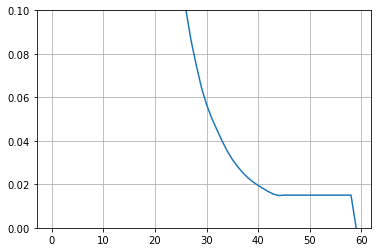

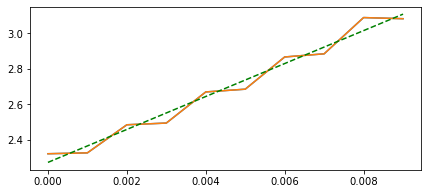

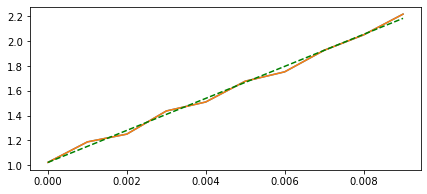

         G212
0   92.628898
1  129.162694
2    0.056581
3    0.017801
4    0.048604
5   46.376854
6  139.441036
7   50.000000
8   50.000000
9  100.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G301/
[418, 12582, 12402]


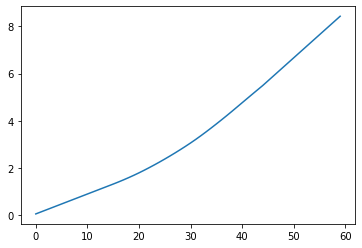

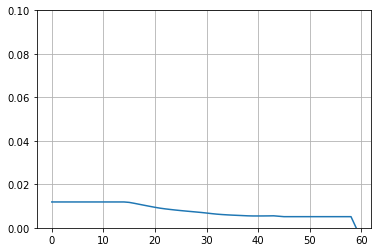

próbka: G301  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G302/
[443, 12606, 12426]


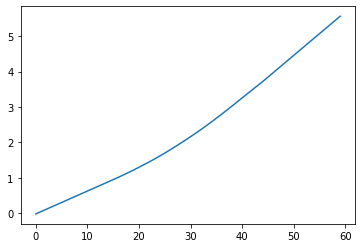

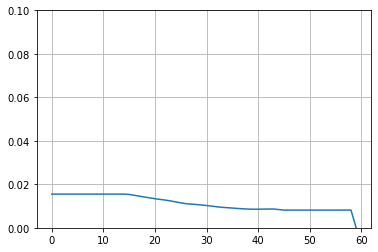

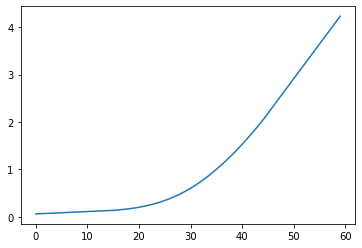

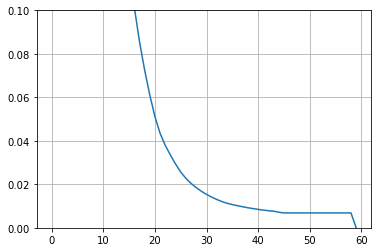

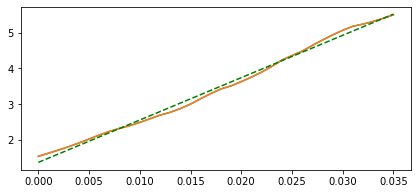

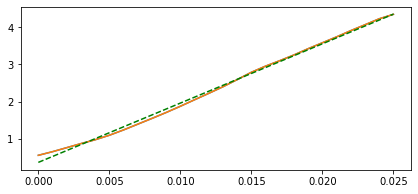

         G302
0  118.552115
1  159.363676
2    0.099081
3         NaN
4    0.074339
5   48.476697
6  134.424997
7   24.000000
8   34.000000
9   70.588235
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G303/
[441, 12604, 12424]


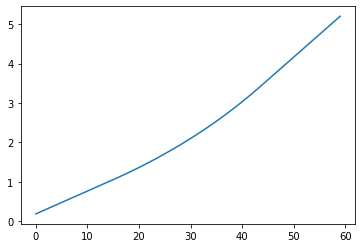

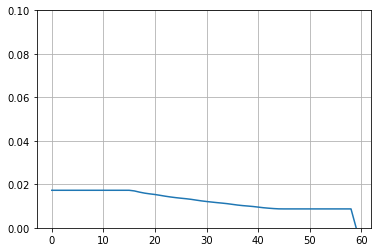

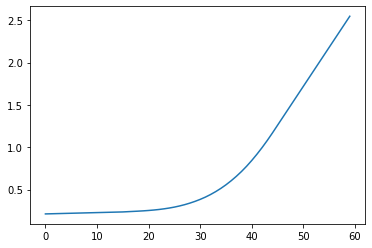

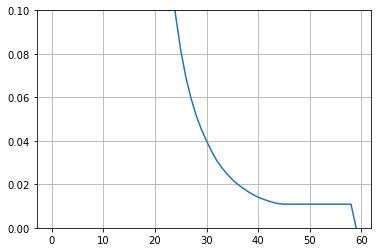

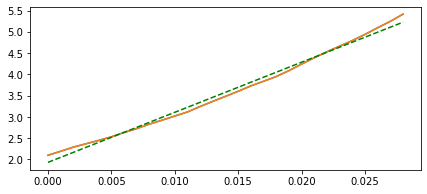

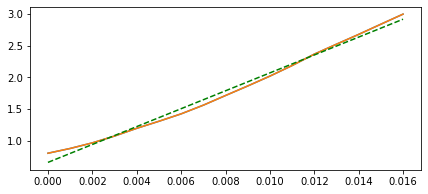

         G303
0  117.760264
1  141.472861
2    0.103664
3         NaN
4    0.093253
5   53.380798
6  120.136332
7   31.000000
8   43.000000
9   72.093023
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G304/
[456, 12619, 12439]


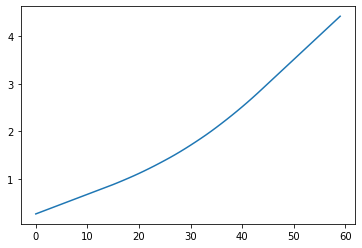

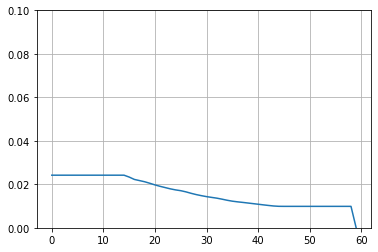

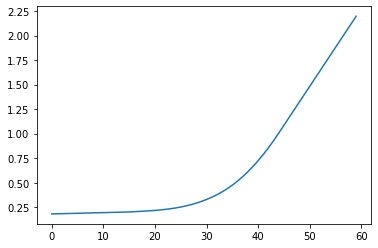

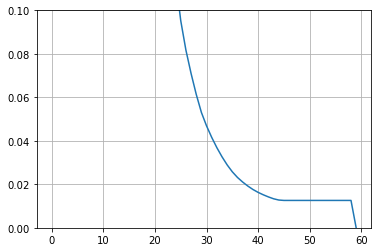

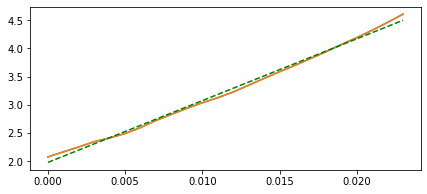

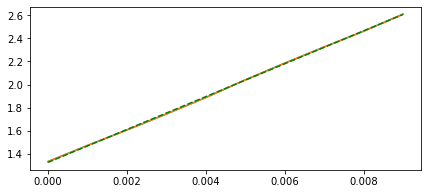

         G304
0  109.462927
1  142.029806
2    0.085018
3         NaN
4    0.077493
5   48.205881
6  129.751515
7   36.000000
8   50.000000
9   72.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G305/
próbka: G305  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G306/
[529, 12693, 12513]


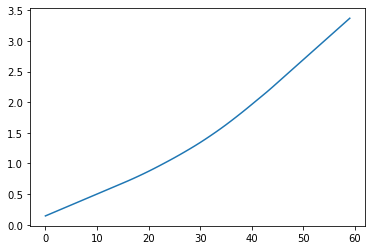

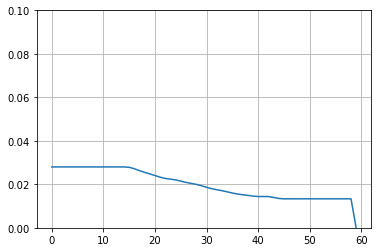

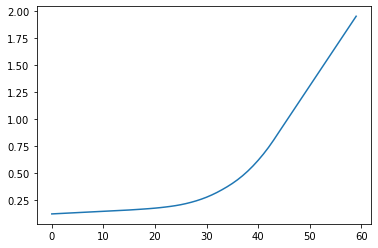

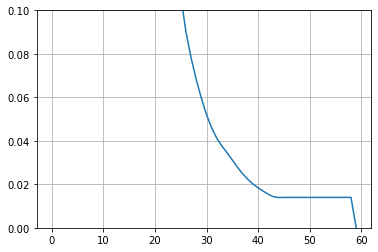

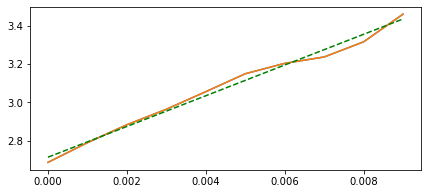

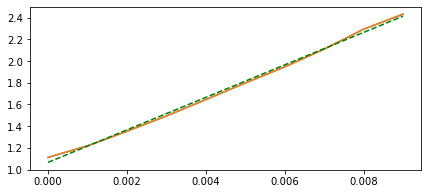

         G306
0   80.150331
1  149.734640
2    0.067936
3         NaN
4    0.056760
5   50.196364
6  186.817244
7   50.000000
8   50.000000
9  100.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G307/
[419, 12582, 12402]


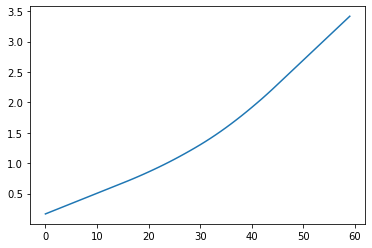

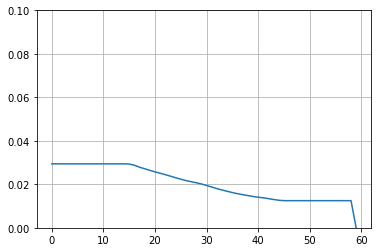

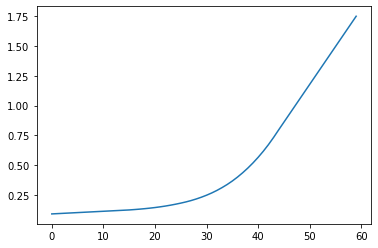

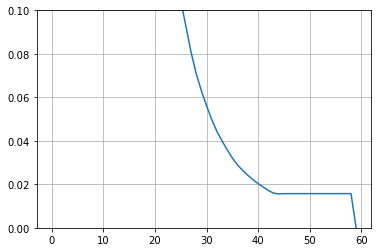

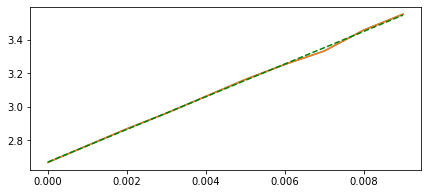

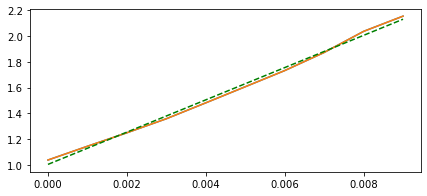

         G307
0   97.285153
1  125.364831
2    0.070198
3         NaN
4    0.059405
5   57.463613
6  128.863271
7   50.000000
8   50.000000
9  100.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G308/
[480, 12644, 12464]


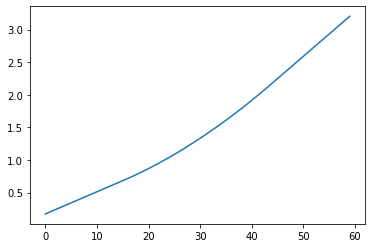

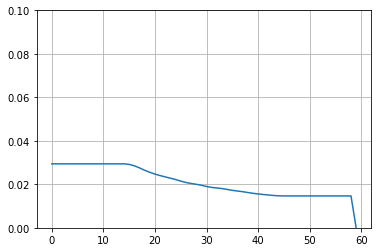

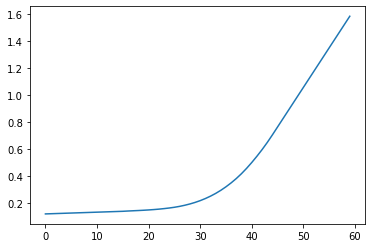

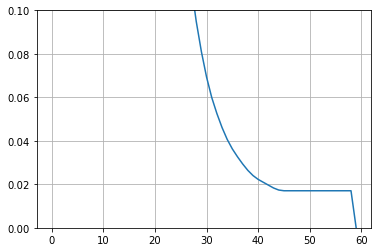

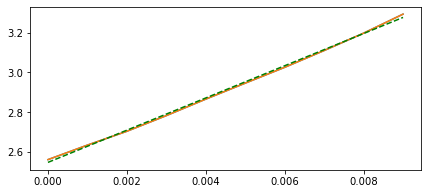

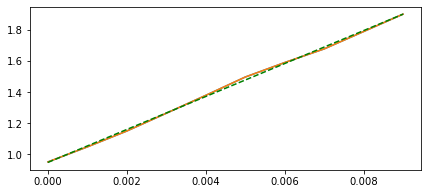

         G308
0   81.158391
1  105.718116
2    0.070668
3         NaN
4    0.060908
5   56.043302
6  130.261473
7   50.000000
8   50.000000
9  100.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G309/
[419, 12582, 12402]


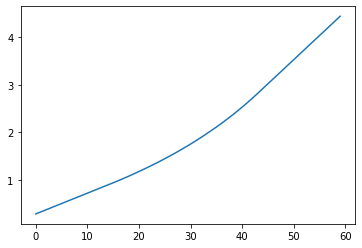

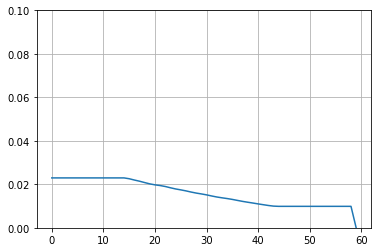

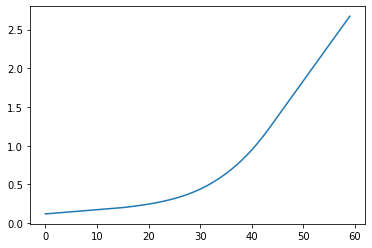

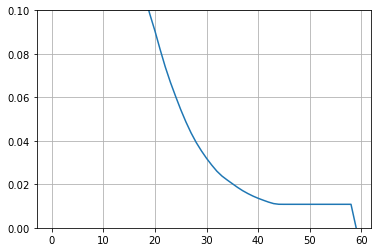

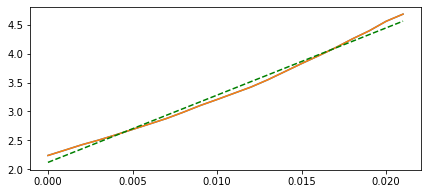

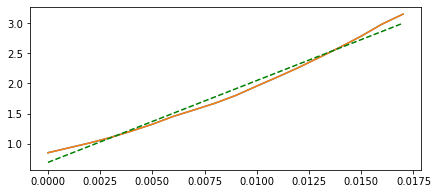

         G309
0  116.454649
1  136.081871
2    0.086505
3         NaN
4    0.071996
5   46.090343
6  116.853962
7   38.000000
8   42.000000
9   90.476190
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G310/
[480, 12643, 12463]


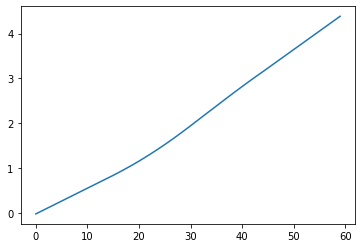

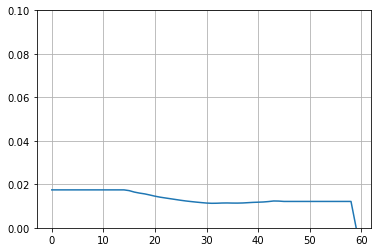

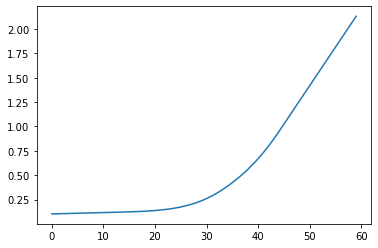

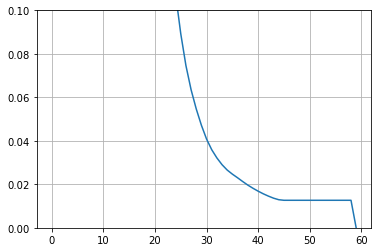

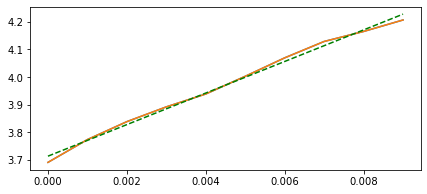

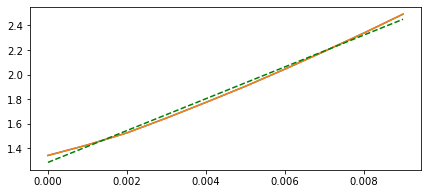

         G310
0   57.270719
1  129.304336
2    0.097515
3         NaN
4    0.086834
5   60.889894
6  225.777392
7   50.000000
8   50.000000
9  100.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G311/
próbka: G311  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G312/
próbka: G312  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G401/
[491, 12655, 12475]


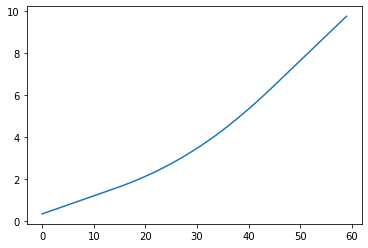

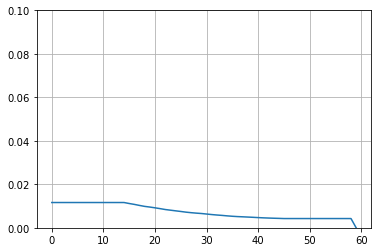

próbka: G401  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G402/
[504, 12669, 12489]


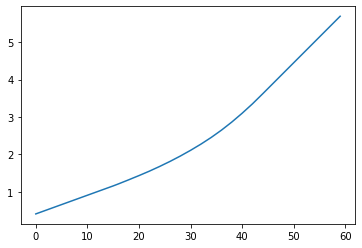

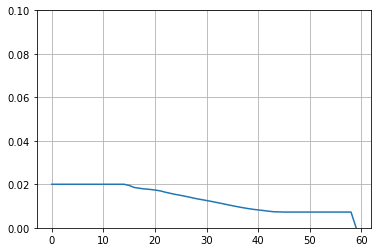

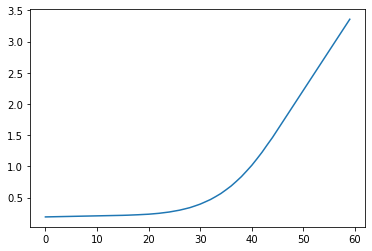

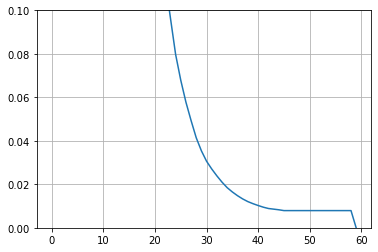

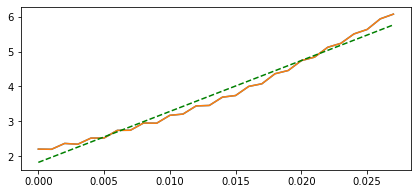

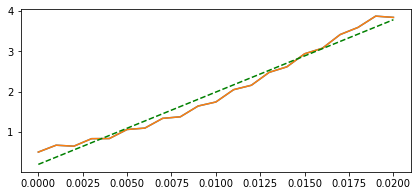

         G402
0  145.790348
1  178.958447
2    0.116402
3         NaN
4    0.093706
5   54.531457
6  122.750545
7   32.000000
8   39.000000
9   82.051282
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G403/
[369, 12532, 12352]


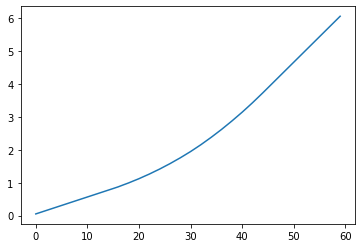

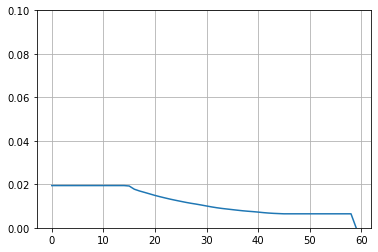

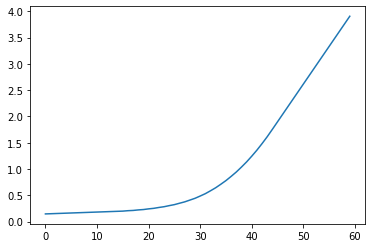

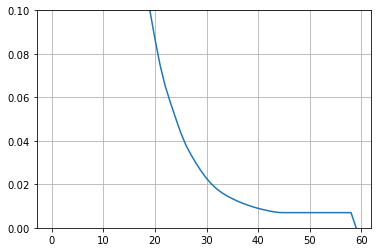

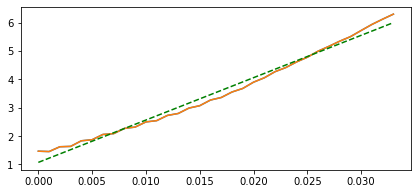

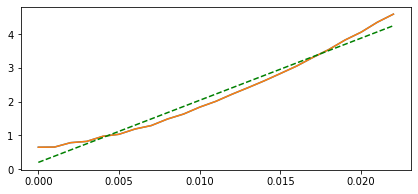

         G403
0  149.308383
1  184.028064
2    0.094519
3    0.039105
4    0.077399
5   46.411901
6  123.253672
7   26.000000
8   37.000000
9   70.270270
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G404/
[430, 12594, 12414]


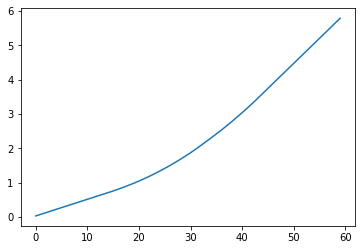

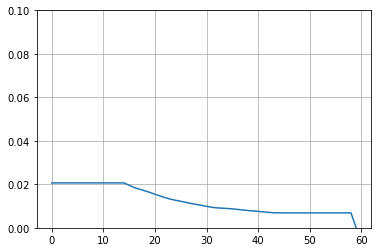

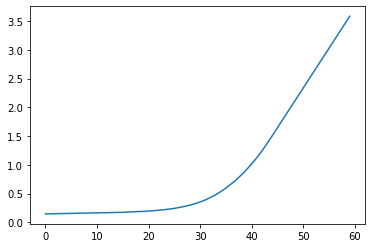

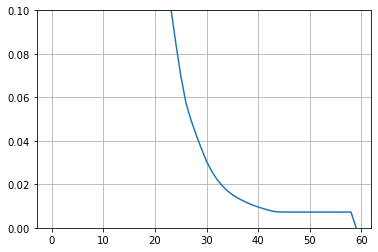

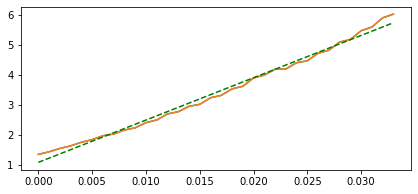

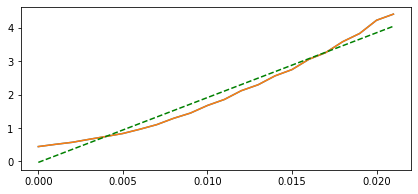

         G404
0  141.325082
1  193.871425
2    0.092650
3         NaN
4    0.079800
5   48.949094
6  137.181187
7   26.000000
8   38.000000
9   68.421053
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G405/
[480, 12644, 12464]


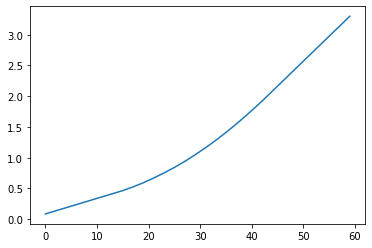

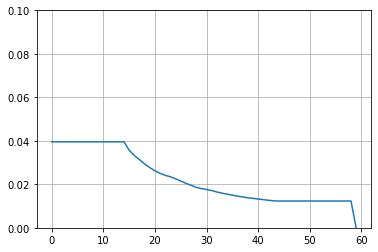

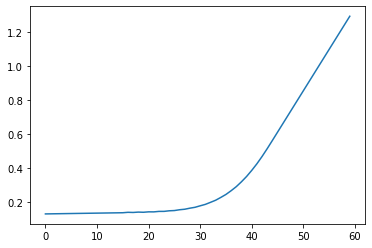

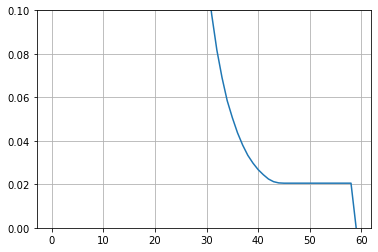

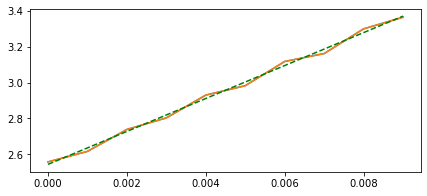

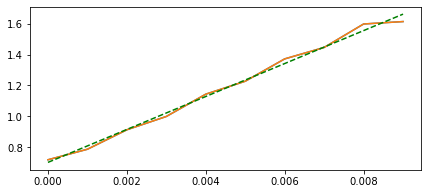

         G405
0   91.794483
1  106.830599
2    0.063487
3         NaN
4    0.055235
5   64.663918
6  116.380195
7   50.000000
8   50.000000
9  100.000000
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G406/
próbka: G406  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G407/
próbka: G407  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G408/
próbka: G408  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G409/
[368, 12533, 12353]


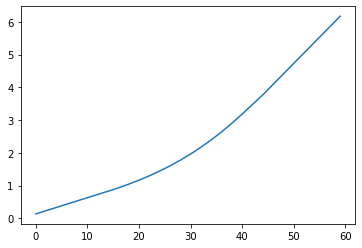

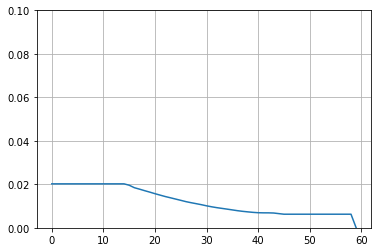

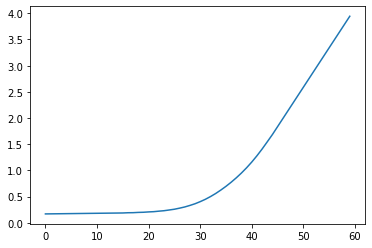

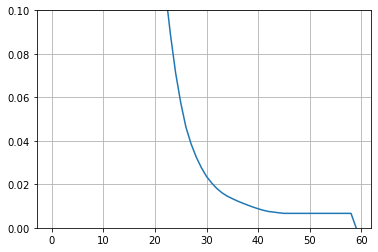

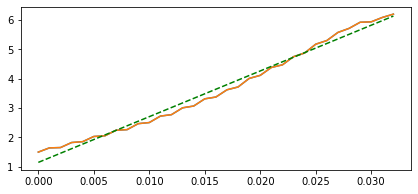

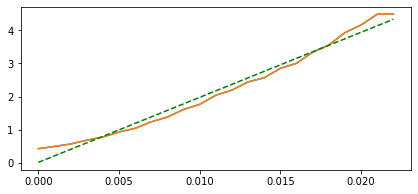

         G409
0  155.382614
1  196.003481
2    0.108928
3    0.042843
4    0.083232
5   52.633856
6  126.142479
7   27.000000
8   37.000000
9   72.972973
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G410/
[456, 12619, 12439]


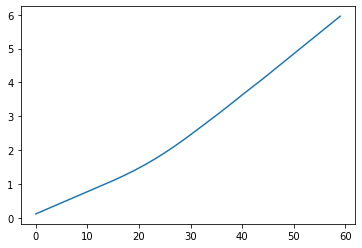

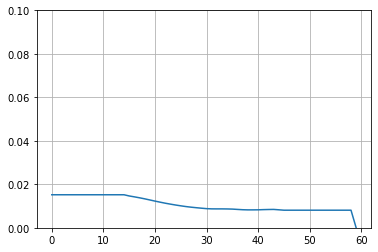

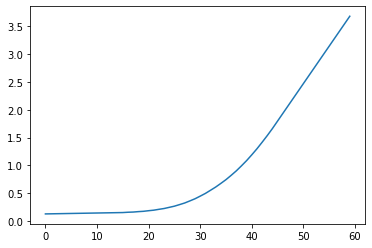

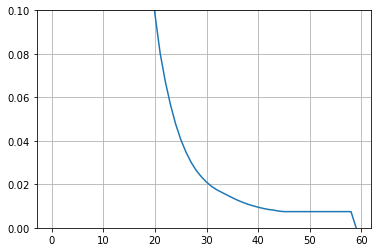

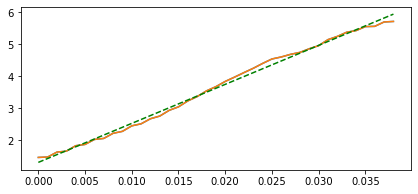

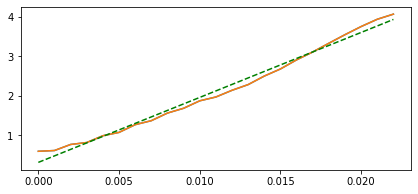

         G410
0  122.024063
1  164.226323
2    0.120470
3         NaN
4    0.101270
5   49.904114
6  134.585195
7   21.000000
8   37.000000
9   56.756757
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G411/
[442, 12605, 12425]


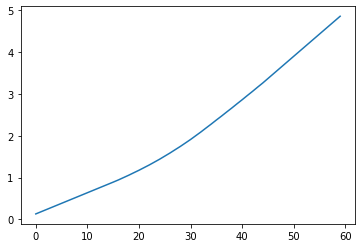

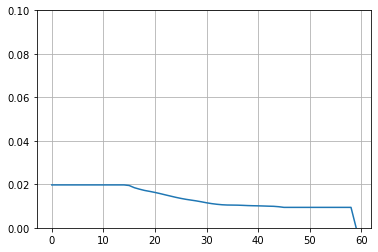

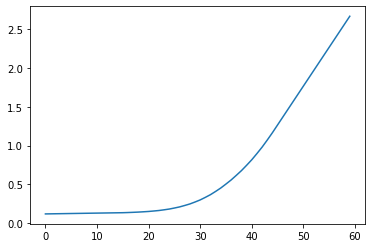

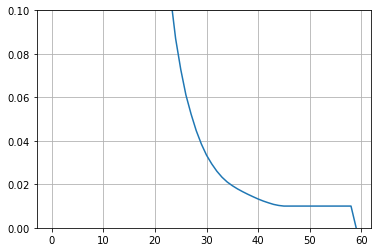

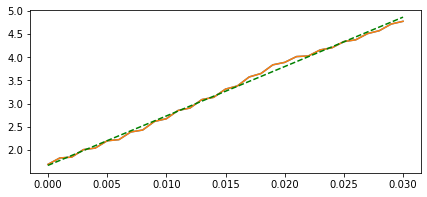

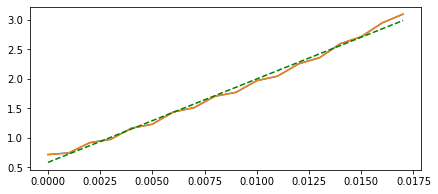

         G411
0  106.460223
1  141.476247
2    0.097654
3         NaN
4    0.085636
5   54.648847
6  132.891180
7   29.000000
8   42.000000
9   69.047619
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G412/
próbka: G412  jest uszkodzona/odrzucona etc...
{1:                0           1         2   3         4          5           6  \
G112  100.181579  132.680485  0.066310 NaN  0.049039  45.564865  132.440002   
G111   92.229070  136.694344  0.085601 NaN  0.071628  57.232191  148.211778   
G110   84.818687  103.393028  0.037473 NaN  0.028940  47.662602  121.898879   
G109   57.979718   77.888608  0.030424 NaN  0.023304  47.795153  134.337680   
G108  129.739895  148.716859  0.076804 NaN  0.060463  43.938734  114.626930   
G106  113.142586  135.100993  0.074583 NaN  0.061614  50.246596  119.407730   
G103   84.244226  111.603834  0.044612 NaN  0.037848  51.504580  132.476537   
G102  105.123168  122.543485  0.050011 NaN  0.043079  56.940517  1

In [6]:

d =  {j: dataProcessing(j) for j in numberOfGroup}
print(d)
#dfData = pd.DataFrame.from_dict(d, orient="index")
#print(dfData)

In [7]:
#print(dfData) col_one_list = df['one'].tolist()
#dfData.iloc[:, dfData.columns.get_level_values(0)=='1'] 
#print(d)
l=list(d.values())

def returnDfOfGroups(l,parametr):
    newDF=pd.DataFrame({'A' : []})
    j=0
    for i in numberOfGroup:  
        newDF=pd.concat([newDF.reindex(newDF.index), pd.DataFrame(l[j][parametr].tolist(), columns=['G'+str(i)])], axis=1)
        j=j+1
    newDF.drop('A', inplace=True, axis=1)
    return newDF


parameters={'Young_1':0,'Young_2':1,'AreaOfHis_1':2,'AreaOfHis_2':3,
            'AreaOfHis_pseudo':4,'DropOfStress':5,'DropOfYoung':6,
            'InflectionPoint_1':7,'InflectionPoint_2':8,'InflectionPointDrop':9}

#print(returnDfOfGroups(l,parameters['Young_1']))

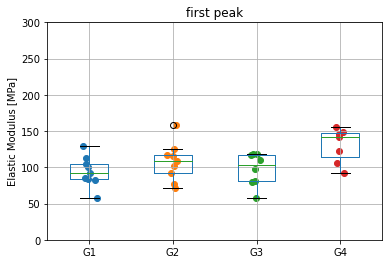

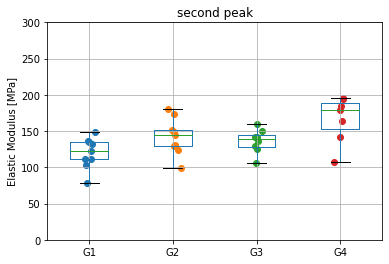

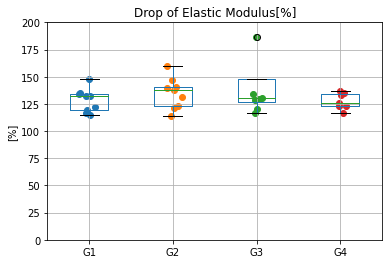

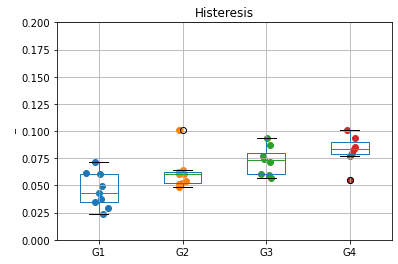

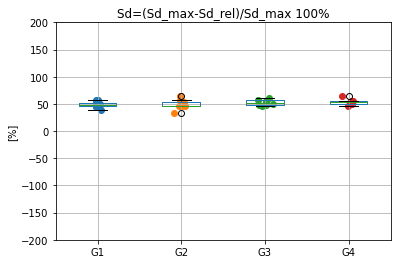

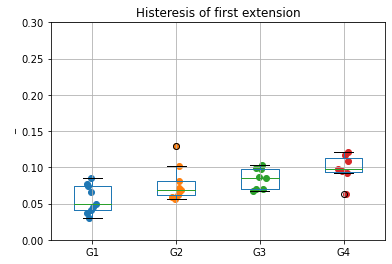

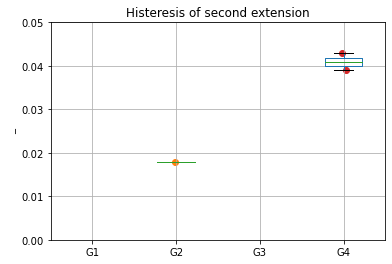

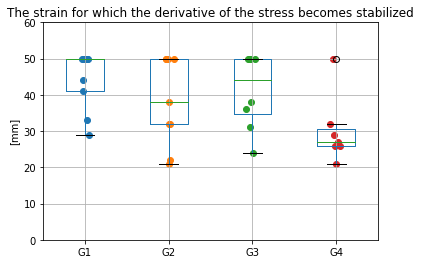

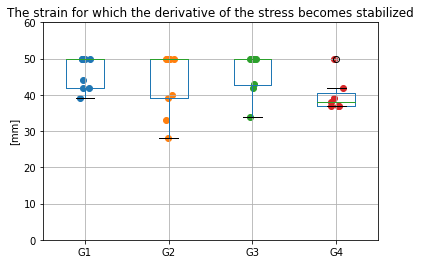

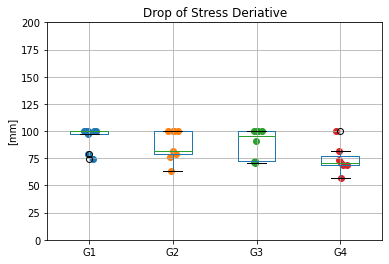

In [8]:
ploting=Ploting()
# box_scatter_plot(df,ylabel,               title,     ylim)    
ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['Young_1']),'Young_1','Elastic Modulus [MPa]','first peak',0,300)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['Young_2']),'Young_2','Elastic Modulus [MPa]','second peak',0,300)
                 
ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['DropOfYoung']),'DropOfYoung','[%]','Drop of Elastic Modulus[%]',0,200)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['AreaOfHis_pseudo']),'AreaOfHis_pseudo','_','Histeresis',0,0.2)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['DropOfStress']),'DropOfStress','[%]','Sd=(Sd_max-Sd_rel)/Sd_max 100%',-200,200)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['AreaOfHis_1']),'AreaOfHis_1','_','Histeresis of first extension',0,0.3)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['AreaOfHis_2']),'AreaOfHis_2','_','Histeresis of second extension',0,0.05)
#'''
ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['InflectionPoint_1']),'InflectionPoint_1','[mm]','The strain for which the derivative of the stress becomes stabilized',0,60)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['InflectionPoint_2']),'InflectionPoint_2','[mm]','The strain for which the derivative of the stress becomes stabilized',0,60)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['InflectionPointDrop']),'InflectionPointDrop','[mm]','Drop of Stress Deriative',0,200)
#'''

first peak
pvalue = 0.02518341751353159 F=3.599957337480063

p<0.05

Anderson bez poprawki Bonferroniego
          G1        G2        G3        G4
G1  1.000000  0.250000  0.250000  0.010676
G2  0.250000  1.000000  0.250000  0.189681
G3  0.250000  0.250000  1.000000  0.020894
G4  0.010676  0.189681  0.020894  1.000000
Ttest bez poprawki Bonferroniego
          G1        G2        G3        G4
G1  1.000000  0.262025  0.790704  0.006317
G2  0.262025  1.000000  0.409407  0.096075
G3  0.790704  0.409407  1.000000  0.016597
G4  0.006317  0.096075  0.016597  1.000000
Ttest z poprawką Bonferroniego
          G1       G2       G3        G4
G1  1.000000  1.00000  1.00000  0.037905
G2  1.000000  1.00000  1.00000  0.576450
G3  1.000000  1.00000  1.00000  0.099580
G4  0.037905  0.57645  0.09958  1.000000


D:\Anaconda3\lib\site-packages\scikit_posthocs\_posthocs.py:1214: UserWarning: p-value capped: true value larger than 0.25
  vs[i, j] = ss.anderson_ksamp([x.loc[x[_group_col] == groups[i], _val_col], x.loc[x[_group_col] == groups[j], _val_col]], midrank=midrank)[2]


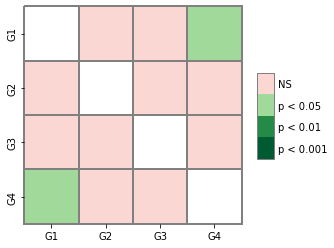

second peak
pvalue = 0.006529463909184461 F=4.988274484815882

p<0.05

Anderson bez poprawki Bonferroniego
          G1        G2        G3        G4
G1  1.000000  0.125551  0.142882  0.007654
G2  0.125551  1.000000  0.250000  0.107385
G3  0.142882  0.250000  1.000000  0.026582
G4  0.007654  0.107385  0.026582  1.000000
Ttest bez poprawki Bonferroniego
          G1        G2        G3        G4
G1  1.000000  0.057897  0.104825  0.003837
G2  0.057897  1.000000  0.554723  0.114619
G3  0.104825  0.554723  1.000000  0.035740
G4  0.003837  0.114619  0.035740  1.000000
Ttest z poprawką Bonferroniego
          G1        G2        G3        G4
G1  1.000000  0.347381  0.628950  0.023020
G2  0.347381  1.000000  1.000000  0.687715
G3  0.628950  1.000000  1.000000  0.214437
G4  0.023020  0.687715  0.214437  1.000000


D:\Anaconda3\lib\site-packages\scikit_posthocs\_posthocs.py:1214: UserWarning: p-value capped: true value larger than 0.25
  vs[i, j] = ss.anderson_ksamp([x.loc[x[_group_col] == groups[i], _val_col], x.loc[x[_group_col] == groups[j], _val_col]], midrank=midrank)[2]


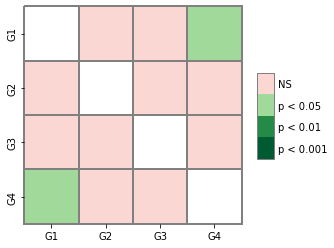

Drop off stress
pvalue = 0.4652569608919672 F=0.8752428591572077

niby histereza
pvalue = 0.00026080653029471996 F=8.816373381984107

p<0.05

Anderson bez poprawki Bonferroniego
          G1        G2        G3        G4
G1  1.000000  0.051802  0.005335  0.001509
G2  0.051802  1.000000  0.099620  0.021000
G3  0.005335  0.099620  1.000000  0.207306
G4  0.001509  0.021000  0.207306  1.000000
Ttest bez poprawki Bonferroniego
          G1        G2        G3        G4
G1  1.000000  0.048895  0.002046  0.000355
G2  0.048895  1.000000  0.147525  0.018200
G3  0.002046  0.147525  1.000000  0.198042
G4  0.000355  0.018200  0.198042  1.000000
Ttest z poprawką Bonferroniego
          G1        G2        G3        G4
G1  1.000000  0.293370  0.012278  0.002130
G2  0.293370  1.000000  0.885148  0.109203
G3  0.012278  0.885148  1.000000  1.000000
G4  0.002130  0.109203  1.000000  1.000000


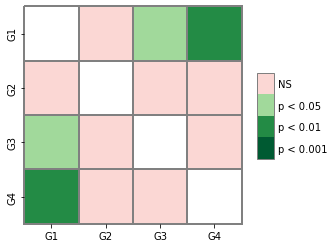

spadek Modulow
pvalue = 0.28130719204992544 F=1.337857869741217

His 1
pvalue = 0.0015212869956016607 F=6.621574421685534

p<0.05

Anderson bez poprawki Bonferroniego
          G1        G2        G3        G4
G1  1.000000  0.099215  0.009819  0.002120
G2  0.099215  1.000000  0.155997  0.080961
G3  0.009819  0.155997  1.000000  0.154042
G4  0.002120  0.080961  0.154042  1.000000
Ttest bez poprawki Bonferroniego
          G1        G2        G3        G4
G1  1.000000  0.060837  0.004035  0.000658
G2  0.060837  1.000000  0.432328  0.067777
G3  0.004035  0.432328  1.000000  0.126243
G4  0.000658  0.067777  0.126243  1.000000
Ttest z poprawką Bonferroniego
          G1        G2        G3        G4
G1  1.000000  0.365024  0.024207  0.003947
G2  0.365024  1.000000  1.000000  0.406662
G3  0.024207  1.000000  1.000000  0.757456
G4  0.003947  0.406662  0.757456  1.000000


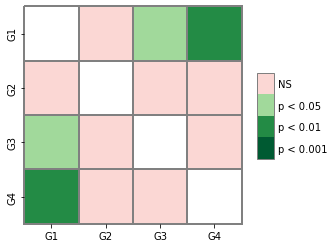

His 2


"\nprint('InflectionPoint_1')\nStaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPoint_1']))\nprint('InflectionPoint_2')\nStaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPoint_2']))\nprint('InflectionPointDrop')\nStaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPointDrop']))\n"

In [9]:
print('first peak')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['Young_1']),'Young_1')
print('second peak')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['Young_2']),'Young_2')
print('Drop off stress')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['DropOfStress']),'DropOfStress')
print('niby histereza')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['AreaOfHis_pseudo']),'AreaOfHis_pseudo')
print('spadek Modulow')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['DropOfYoung']),'DropOfYoung')
print('His 1')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['AreaOfHis_1']),'AreaOfHis_1')
print('His 2')
#StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['AreaOfHis_2']))

'''
print('InflectionPoint_1')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPoint_1']))
print('InflectionPoint_2')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPoint_2']))
print('InflectionPointDrop')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPointDrop']))
'''